- aplicar a metodologia para o drug200 (drugX = 1) - testando validação cruzada de Árvore de Decisão - plotar a árvore de decisão

In [43]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, make_scorer

# ignorar warnings (opcional)
warnings.filterwarnings('ignore')

In [2]:
# conectar o colab ao Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# lendo os dados
PATH = '/content/drive/MyDrive/Bootcamp_DataScience/AlgoritmosInteligenciaArtificialClassificacao/datasets/drug200.csv'
data = pd.read_csv(PATH)
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
# analisar a tipagem dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


<Axes: >

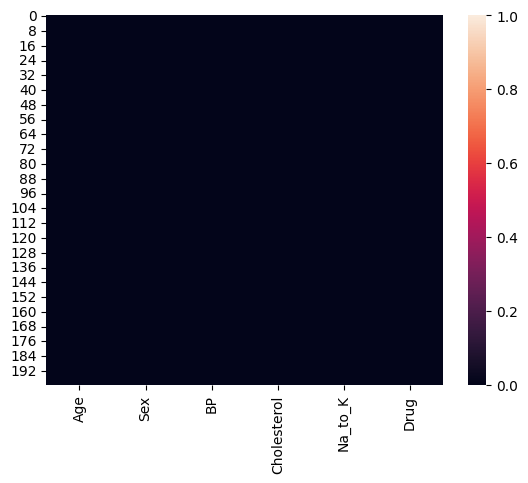

In [5]:
# analise de dados nulos
sns.heatmap(data.isna(), vmin=0, vmax=1)

In [6]:
# (opcional) modificar os nomes das colunas
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
data.head(1)

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,DrugY


In [7]:
# transformar o dataset para classificação binária - drugX = 1 / 0 caso contrário
target = 'drugX'
data['drug'] = data['drug'].apply(lambda x: 1 if x == target else 0)
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,0
1,47,M,LOW,HIGH,13.093,0
2,47,M,LOW,HIGH,10.114,0
3,28,F,NORMAL,HIGH,7.798,1
4,61,F,LOW,HIGH,18.043,0


In [8]:
# verificar o balanceamento das classes
data['drug'].value_counts(normalize=True)

,proportion
drug,
0,0.73
1,0.27


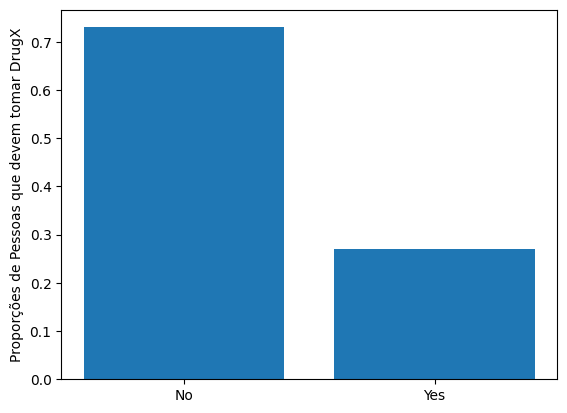

In [9]:
# outra forma de ver o balanceamento de classes
proportions = data['drug'].value_counts(normalize=True)

plt.bar(x=proportions.index, height=proportions.values)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.ylabel('Proporções de Pessoas que devem tomar DrugX')
plt.show()

In [10]:
# para iniciar - apenas variáveis numéricas (reais)
data_num = data[['drug', 'age', 'na_to_k']]
data_num.head()

,drug,age,na_to_k
0,0,23,25.355
1,0,47,13.093
2,0,47,10.114
3,1,28,7.798
4,0,61,18.043


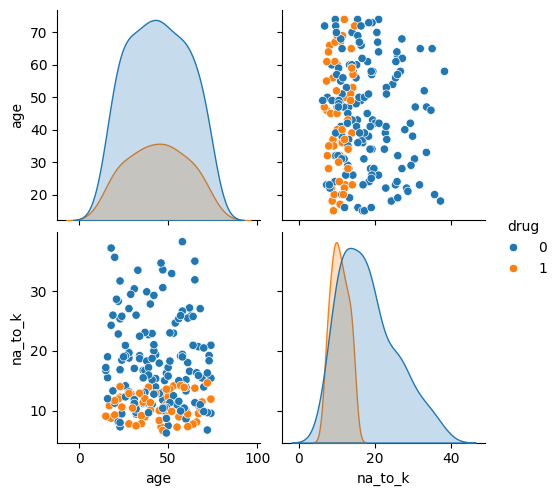

In [11]:
# analise de separabilidade linear (visual)
sns.pairplot(data, hue='drug')

In [12]:
# separando x e y
target = 'drug'
x = data_num.drop(columns=[target])
y = data_num[[target]]

In [13]:
# separação treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=2)

In [14]:
# analise de proporções
props = pd.DataFrame(y.value_counts(normalize=True).values, columns=['original'])
props['train'] = y_train.value_counts(normalize=True).values
props['test'] = y_test.value_counts(normalize=True).values
props

,original,train,test
0,0.73,0.728571,0.733333
1,0.27,0.271429,0.266667


In [15]:
# criar um modelo baseline - hipótese: todos não devem tomar a drugX (todos = 0)
y_base = np.repeat(0, repeats=y_test.shape[0])
y_base

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# métricas do baseline
print(classification_report(y_test, y_base))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85        44
           1       0.00      0.00      0.00        16

    accuracy                           0.73        60
   macro avg       0.37      0.50      0.42        60
weighted avg       0.54      0.73      0.62        60



In [17]:
# criando um pipeline
dt2 = Pipeline([
    ('model', DecisionTreeClassifier(random_state=2))
])

# configurar o espaço de busca
params_grid = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy']
}

# configurar o amostrador - estratificado
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

# configurar o buscador
search_dt2 = GridSearchCV(
    estimator=dt2,
    param_grid=params_grid,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [18]:
# busca de hiperparâmetros
search_dt2.fit(x_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 1/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.500 total time=   0.0s
[CV 2/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 2/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.667 total time=   0.0s
[CV 3/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 3/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.400 total time=   0.0s
[CV 4/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 4/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.400 total time=   0.0s
[CV 5/10; 1/18] START model__criterion=gini, model__max_depth=2.................
[CV 5/10; 1/18] END model__criterion=gini, model__max_depth=2;, score=0.400 total time=   0.0s
[CV 6/10; 1/18] START model__criterion=gini, model__max_d

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeClassifier(random_state=2))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(2, 11)},
             scoring='f1', verbose=10)

In [19]:
# melhor combinação de parâmetros
search_dt2.best_params_

{'model__criterion': 'gini', 'model__max_depth': 3}

In [20]:
# analisando o melhor desempenho médio
search_dt2.best_score_

0.5126190476190475

In [21]:
# analisar o desempenho final

# realizando novas previsões
yhat_dt2_train = search_dt2.best_estimator_.predict(x_train)
yhat_dt2_test = search_dt2.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_dt2_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_dt2_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       102
           1       0.64      0.79      0.71        38

    accuracy                           0.82       140
   macro avg       0.78      0.81      0.79       140
weighted avg       0.84      0.82      0.83       140

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.85      0.75      0.80        44
           1       0.48      0.62      0.54        16

    accuracy                           0.72        60
   macro avg       0.66      0.69      0.67        60
weighted avg       0.75      0.72      0.73        60



In [22]:
# obtendo os resultados da validação cruzada - média de cada split
search_dt2.cv_results_['mean_test_score']

array([0.47349206, 0.51261905, 0.36787879, 0.38444444, 0.44168831,
       0.44168831, 0.41406926, 0.42168831, 0.46454545, 0.33777778,
       0.44428571, 0.40478355, 0.37015873, 0.39645022, 0.43978355,
       0.37311688, 0.36835498, 0.44025974])

In [23]:
# obtendo os resultados da validação cruzada - desvio padrão de cada split
search_dt2.cv_results_['std_test_score']

array([0.15714454, 0.18646992, 0.16253388, 0.18      , 0.13820689,
       0.13820689, 0.12109414, 0.13470877, 0.14248179, 0.19059361,
       0.22090363, 0.20023333, 0.16864405, 0.18698871, 0.13725558,
       0.15821649, 0.16004821, 0.1098776 ])

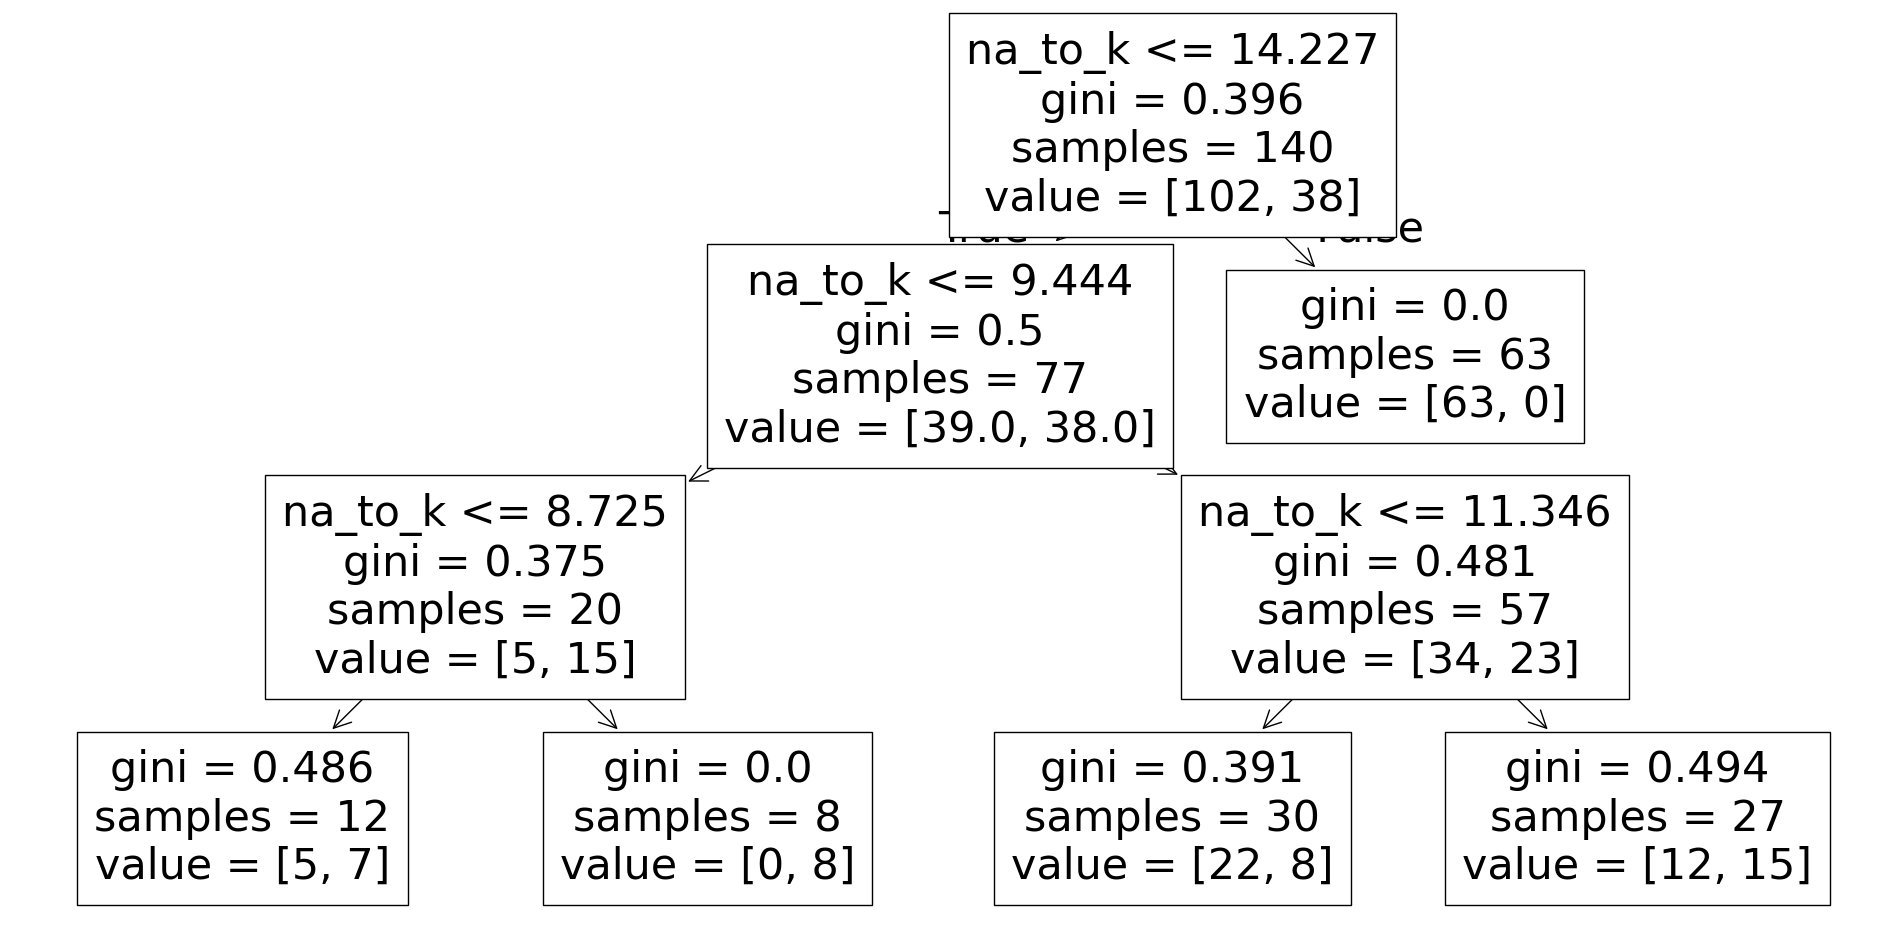

In [24]:
# visualizar a árvore construída
plt.figure(figsize=(24, 12))
plot_tree(search_dt2.best_estimator_['model'], feature_names=x_train.columns)
plt.show()

- DESAFIO - aplicar validação cruzada e seleção de hiperparâmetros para Reg. Logística

In [25]:
# criando um pipeline de Regressão Log.
reglog = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(solver='saga'))
])

# configurar o espaço de busca
params_grid = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None]
}

# configurar o buscador
search_reglog = GridSearchCV(
    estimator=reglog,
    param_grid=params_grid,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [26]:
# realizar a busca
search_reglog.fit(x_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV 1/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 1/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.353 total time=   0.1s
[CV 2/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 2/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.000 total time=   0.1s
[CV 3/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 3/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.000 total time=   0.1s
[CV 4/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 4/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ra

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__class_weight': ['balanced', None],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='f1', verbose=10)

In [27]:
# melhor combinação de parâmetros
search_reglog.best_params_

{'model__C': 0.01,
 'model__class_weight': 'balanced',
 'model__l1_ratio': 0.25,
 'model__penalty': 'elasticnet'}

In [28]:
# analisando o melhor desempenho médio
search_reglog.best_score_

0.6459540459540459

In [29]:
# analisar o desempenho final
# realizando novas previsões
yhat_dt2_train = search_reglog.best_estimator_.predict(x_train)
yhat_dt2_test = search_reglog.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_dt2_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_dt2_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       102
           1       0.49      0.97      0.65        38

    accuracy                           0.71       140
   macro avg       0.74      0.80      0.70       140
weighted avg       0.85      0.71      0.73       140

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.97      0.66      0.78        44
           1       0.50      0.94      0.65        16

    accuracy                           0.73        60
   macro avg       0.73      0.80      0.72        60
weighted avg       0.84      0.73      0.75        60



- DESAFIO - tentar usar as variáveis categóricas para o drug200

In [30]:
data.head()

,age,sex,bp,cholesterol,na_to_k,drug
0,23,F,HIGH,HIGH,25.355,0
1,47,M,LOW,HIGH,13.093,0
2,47,M,LOW,HIGH,10.114,0
3,28,F,NORMAL,HIGH,7.798,1
4,61,F,LOW,HIGH,18.043,0


In [31]:
# definir variáveis numéricas e categóricas
categ = ['sex', 'bp', 'cholesterol']
num = ['age', 'na_to_k']

In [32]:
# separando x e y
target = 'drug'
x = data.drop(columns=[target])
y = data[[target]]

# separação treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=2)

In [33]:
# criando um pipeline de processamento
preprocessor = ColumnTransformer([
    ('category', OneHotEncoder(drop='first'), categ),
    ('numeric', RobustScaler(), num)
])

# criando os pipelines
dt_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', DecisionTreeClassifier(random_state=2))
])
reglog_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', LogisticRegression(solver='saga'))
])

# configurar o espaço de busca
params_grid_dt = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None]
}
params_grid_reglog = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None]
}

# configurar o buscador
search_dt_categ = GridSearchCV(
    estimator=dt_categ,
    param_grid=params_grid_dt,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)
search_reg_log_categ = GridSearchCV(
    estimator=reglog_categ,
    param_grid=params_grid_reglog,
    scoring='f1',
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [34]:
# treinando o dt
search_dt_categ.fit(x_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 1/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.800 total time=   0.1s
[CV 2/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 2/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=1.000 total time=   0.1s
[CV 3/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 3/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.667 total time=   0.1s
[CV 4/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 4/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=0.667 total time=   0.0s
[CV 5/10; 1/36] START model__class_weight=balanced, model__cr

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('category',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'bp',
                                                                          'cholesterol']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'na_to_k'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2))]),
             param_grid={'model__class_weight': ['balanced', None],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(2, 11)},
             scoring='f1', verbose=10)

In [35]:
# treinando o reglog
search_reg_log_categ.fit(x_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV 1/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 1/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.353 total time=   0.0s
[CV 2/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 2/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.000 total time=   0.0s
[CV 3/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 3/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=0.444 total time=   0.0s
[CV 4/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 4/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ra

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('category',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'bp',
                                                                          'cholesterol']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'na_to_k'])])),
                                       ('model',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__class_weight': ['balanced', None],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring='f1', verbose=10)

In [36]:
# melhor combinação de parâmetros
search_dt_categ.best_params_

{'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': 4}

In [37]:
# search_dt_categ.best_estimator_['transformer'].transform(x_train)

In [38]:
# analisando o melhor desempenho médio
search_dt_categ.best_score_

1.0

In [39]:
# analisar o desempenho final
# realizando novas previsões
yhat_dt_categ_train = search_dt_categ.best_estimator_.predict(x_train)
yhat_dt_categ_test = search_dt_categ.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_dt_categ_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_dt_categ_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        38

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        44
           1       1.00      0.88      0.93        16

    accuracy                           0.97        60
   macro avg       0.98      0.94      0.96        60
weighted avg       0.97      0.97      0.97        60



In [40]:
# melhor combinação de parâmetros
search_reg_log_categ.best_params_

{'model__C': 0.001,
 'model__class_weight': 'balanced',
 'model__l1_ratio': 0.25,
 'model__penalty': None}

In [41]:
# analisando o melhor desempenho médio
search_reg_log_categ.best_score_

0.9149206349206349

In [42]:
# analisar o desempenho final
# realizando novas previsões
yhat_reg_log_categ_train = search_reg_log_categ.best_estimator_.predict(x_train)
yhat_reg_log_categ_test = search_reg_log_categ.best_estimator_.predict(x_test)

# análise do desempenho
print('Desempenho - Base de Treino')
print(classification_report(y_train, yhat_reg_log_categ_train))

print('Desempenho - Base de Teste')
print(classification_report(y_test, yhat_reg_log_categ_test))

Desempenho - Base de Treino
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       102
           1       0.90      1.00      0.95        38

    accuracy                           0.97       140
   macro avg       0.95      0.98      0.96       140
weighted avg       0.97      0.97      0.97       140

Desempenho - Base de Teste
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.94      1.00      0.97        16

    accuracy                           0.98        60
   macro avg       0.97      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



- [DESAFIO] - Realizar a validação cruzada utilizando como métrica, o lucro médio por cliente, nas seguintes condições:

 - TP = 100 (a pessoa acertou o remédio que deve tomar e não usou o plano de saúde)
 - FP = -150 (a pessoa errou o remédio e teve de ir ao PS)
 - TN = 100 (a pessoa acertou que não era para tomar o rmédio C e não usou o plano de saúde)
 - FN = -250 (a pessoa deveria tomar o C, mas não tomou, e por isso teve de usar a UTI)

In [44]:
def customer_profit(yreal, ypred):

  # calcula a matriz de confusão
  conf_matrix = confusion_matrix(yreal, ypred)

  # extrai pontuações
  TP = conf_matrix[1, 1]  # Verdadeiros positivos
  FP = conf_matrix[0, 1]  # Falsos positivos
  TN = conf_matrix[0, 0]  # Verdadeiros negativos
  FN = conf_matrix[1, 0]  # Falsos negativos

  # calcula custo
  return ((100 * TP) + (-250 * FN) + (100 * TN) + (-150 * FP)) / yreal.shape[0]

In [45]:
# criando um pipeline de processamento
preprocessor = ColumnTransformer([
    ('category', OneHotEncoder(drop='first'), categ),
    ('numeric', RobustScaler(), num)
])

# criando os pipelines
dt_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', DecisionTreeClassifier(random_state=2))
])
reglog_categ = Pipeline([
    ('transformer', preprocessor),
    ('model', LogisticRegression(solver='saga'))
])

# configurar o espaço de busca
params_grid_dt = {
    'model__max_depth': range(2, 11),
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': ['balanced', None]
}
params_grid_reglog = {
    'model__penalty': ['l1', 'l2', 'elasticnet', None],
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced', None]
}

# configurar o buscador
search_dt_categ = GridSearchCV(
    estimator=dt_categ,
    param_grid=params_grid_dt,
    scoring=make_scorer(customer_profit, greater_is_better=True),
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)
search_reg_log_categ = GridSearchCV(
    estimator=reglog_categ,
    param_grid=params_grid_reglog,
    scoring=make_scorer(customer_profit, greater_is_better=True),
    cv=splitter,
    refit=True,
    error_score=0,
    verbose=10
)

In [46]:
# treinando o decision treesearch_dt_categ.fit(x_train, y_train)


Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 1/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=75.000 total time=   0.0s
[CV 2/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 2/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=100.000 total time=   0.0s
[CV 3/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 3/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=50.000 total time=   0.0s
[CV 4/10; 1/36] START model__class_weight=balanced, model__criterion=gini, model__max_depth=2
[CV 4/10; 1/36] END model__class_weight=balanced, model__criterion=gini, model__max_depth=2;, score=50.000 total time=   0.0s
[CV 5/10; 1/36] START model__class_weight=balanced, mode

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('category',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'bp',
                                                                          'cholesterol']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'na_to_k'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2))]),
             param_grid={'model__class_weight': ['balanced', None],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(2, 11)},
             scoring=make_scorer(customer_profit, response_method='predict'),
             verbose=10)

In [47]:
# treinando o reg_log
search_reg_log_categ.fit(x_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV 1/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 1/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=-96.429 total time=   0.0s
[CV 2/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 2/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=25.000 total time=   0.0s
[CV 3/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 3/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1;, score=-78.571 total time=   0.0s
[CV 4/10; 1/120] START model__C=0.001, model__class_weight=balanced, model__l1_ratio=0.25, model__penalty=l1
[CV 4/10; 1/120] END model__C=0.001, model__class_weight=balanced, model__

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('category',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'bp',
                                                                          'cholesterol']),
                                                                        ('numeric',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'na_to_k'])])),
                                       ('model',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10],
                         'model__class_weight': ['balanced', None],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': ['l1', 'l2', 'elasticnet', None]},
             scoring=make_scorer(customer_profit, response_method='predict'),
             verbose=10)

In [48]:
# analisar a melhor combinação de parâmetros
print('Melhores Parâmetros - Reg. Logística')
print(search_reg_log_categ.best_params_)
print()
print('Melhores Parâmetros - Árvore de Decisão')
print(search_dt_categ.best_params_)

Melhores Parâmetros - Reg. Logística
{'model__C': 0.001, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.25, 'model__penalty': None}

Melhores Parâmetros - Árvore de Decisão
{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4}


In [49]:
# analisar o melhor desempenho médio
print('Melhor Lucro Médio por Cliente - Reg. Logística')
print(search_reg_log_categ.best_score_)
print()
print('Melhor Lucro Médio por Cliente - Árvore de Decisão')
print(search_dt_categ.best_score_)

Melhor Lucro Médio por Cliente - Reg. Logística
86.07142857142858

Melhor Lucro Médio por Cliente - Árvore de Decisão
100.0


In [50]:
# analisando o desempenho final
# realizando novas previsões
yhat3_train_reglog = search_reg_log_categ.best_estimator_.predict(x_train)
yhat3_test_reglog = search_reg_log_categ.best_estimator_.predict(x_test)

print(f'Lucro - Base de Treinamento - Reg. Logística: {customer_profit(y_train, yhat3_train_reglog)}')
print(f'Lucro - Base de Teste - Reg. Logística: {customer_profit(y_test, yhat3_test_reglog)}')

yhat3_train_dt = search_dt_categ.best_estimator_.predict(x_train)
yhat3_test_dt = search_dt_categ.best_estimator_.predict(x_test)

print(f'Lucro - Base de Treinamento - Árvore de Decisão: {customer_profit(y_train, yhat3_train_dt)}')
print(f'Lucro - Base de Teste - Árvore de Decisão: {customer_profit(y_test, yhat3_test_dt)}')

Lucro - Base de Treinamento - Reg. Logística: 92.85714285714286
Lucro - Base de Teste - Reg. Logística: 95.83333333333333
Lucro - Base de Treinamento - Árvore de Decisão: 100.0
Lucro - Base de Teste - Árvore de Decisão: 88.33333333333333
